## Feature Evaluation of AI4I 2020 Predictive Maintenance Dataset

<b>Problem Definition</b>:
Perform an analysis of the given data to determine how different features are related to the target variable i.e. Machine failure.
 Build a machine learning model that can predict the
Machine failure. <br>
<b>Planned Goals</b>: <br>
<b>Achieved Goals</b>: <br>
<b>Contributors</b>: Kayhan B (Oct 2021)<br>
<b>Reviewers</b>: -<br>
<br>

<b>General Information</b>:<br>
- Please read the README for python environment handling. <br>
- More information about the defined problem is presented on: 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset
- Dataset for this problem is tabular and is stored inside the data folder.
<br>

<b> Data Attribute Information (from source)</b>:

The dataset consists of 10 000 data points stored as rows with 14 features in columns <br>
<br>
- <b>UID</b>: unique identifier ranging from 1 to 10000 <br>
<br>
- <b>product ID</b>: consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as 
product quality variants and a variant-specific serial number <br>
<br>
- <b>air temperature [K]</b>: generated using a random walk process later normalized to a standard deviation of 2 K around 
300 K <br>
<br>
- <b>process temperature [K]</b>: generated using a random walk process normalized to a standard deviation of 1 K, added 
to the air temperature plus 10 K. <br>
<br>
- <b>rotational speed [rpm]</b>: calculated from a power of 2860 W, overlaid with a normally distributed noise <br>
<br>
- <b>torque [Nm]</b>: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
<br>
- <b>tool wear [min]</b>: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. <br>
<br>

<b>'machine failure'</b> label that indicates, whether the machine has failed in this particular datapoint for any of the 
following failure modes are true.
<br>

The <b>machine failure</b> consists of five independent failure modes <br>
<br>
- <b>tool wear failure (TWF)</b>: the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240
mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned). <br>
<br>
- <b>heat dissipation failure (HDF)</b>: heat dissipation causes a process failure, if the difference between air- and process
temperature is below 8.6 K and the tool's rotational speed is below 1380 rpm. This is the case for 115 data points. <br>
<br>
- <b>power failure (PWF)</b>: the product of torque and rotational speed (in rad/s) equals the power required for the process.
If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset. <br>
<br>
- <b>overstrain failure (OSF)</b>: if the product of tool wear and torque exceeds 11,000 min Nm for the L product variant
(12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints. <br>
<br>
- <b>random failures (RNF)</b>: each process has a chance of 0.1 % to fail regardless of its process parameters. This is the case
for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset. <br>
<br>

If at least one of the above failure modes is true, the process fails and the <b>'machine failure'</b> label is set to 1.
It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.<br>
<br>

Let's set up the configs, imported modules and take a glance at the data.

In [1]:
# read configuration from config files
from config import settings

cnf = settings.notebook

Notebook is started.
Reading the config file is finished.


In [2]:
# required libraries and helpers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# read data csv and store it in pandas dataframe
df = pd.read_csv(cnf.data_source_path)
print(f"Dataframe length is: {len(df.index)}")
print(f"Number of columns is: {len(df.columns)}")
print(f"Columns inferred types are:")
print(df.dtypes)
df.head(5)

Dataframe length is: 10000
Number of columns is: 14
Columns inferred types are:
UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
# last five rows
df.tail(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0
9999,10000,M24859,M,299.0,308.7,1500,40.2,30,0,0,0,0,0,0


In [5]:
# dataframe info and memory usage
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [6]:
# memory usage of each column in bytes
df.memory_usage(deep = True)

Index                         128
UDI                         80000
Product ID                 630000
Type                       580000
Air temperature [K]         80000
Process temperature [K]     80000
Rotational speed [rpm]      80000
Torque [Nm]                 80000
Tool wear [min]             80000
Machine failure             80000
TWF                         80000
HDF                         80000
PWF                         80000
OSF                         80000
RNF                         80000
dtype: int64

In [7]:
# checking machine failures columns claimed attributes
col_names = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
for col_name in col_names:
    print(f"'{col_name}' column: % of ones in {((df[col_name] == 1).sum() / len(df.index)) * 100 :.2f}, "
          f"% of zeros in {((df[col_name] == 0).sum() / len(df.index)) * 100 :.2f}, "
          f"sum % = {(len(df[(df[col_name] == 0) | (df[col_name] == 1)].index) / len(df.index)) * 100 :.2f}")

'Machine failure' column: % of ones in 3.39, % of zeros in 96.61, sum % = 100.00
'TWF' column: % of ones in 0.46, % of zeros in 99.54, sum % = 100.00
'HDF' column: % of ones in 1.15, % of zeros in 98.85, sum % = 100.00
'PWF' column: % of ones in 0.95, % of zeros in 99.05, sum % = 100.00
'OSF' column: % of ones in 0.98, % of zeros in 99.02, sum % = 100.00
'RNF' column: % of ones in 0.19, % of zeros in 99.81, sum % = 100.00


Target labels are correctly labelled as the sum of the ones and zeros equal to 100%. <br>
Let's check if the condition related to the <b>machine failure modes</b> stated as "if at least one of the failure modes is true,
the process fails and marked as machine failure" is true or not.

In [8]:
(df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0).equals(df['Machine failure'])

False

Therefore, we have machine failure that are not exactly caused by main failure modes or failure modes do not caused the
machine failure.

In [9]:
ser_failure_modes = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0)
df_check_failure_modes = pd.DataFrame()
for index, value in df['Machine failure'].items():
    if value != ser_failure_modes[index]:
        df_check_failure_modes = df_check_failure_modes.append(df.iloc[index])

print(f"Dataframe length is: {len(df_check_failure_modes.index)}")
df_check_failure_modes.head(10)

Dataframe length is: 27


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
1221,1222.0,M16081,M,297.0,308.3,1399.0,46.4,132.0,0.0,0.0,0.0,0.0,0.0,1.0
1302,1303.0,L48482,L,298.6,309.8,1505.0,45.7,144.0,0.0,0.0,0.0,0.0,0.0,1.0
1437,1438.0,H30851,H,298.8,309.9,1439.0,45.2,40.0,1.0,0.0,0.0,0.0,0.0,0.0
1748,1749.0,H31162,H,298.4,307.7,1626.0,31.1,166.0,0.0,0.0,0.0,0.0,0.0,1.0
2072,2073.0,L49252,L,299.6,309.5,1570.0,35.5,189.0,0.0,0.0,0.0,0.0,0.0,1.0
2559,2560.0,L49739,L,299.3,309.0,1447.0,50.4,140.0,0.0,0.0,0.0,0.0,0.0,1.0
2749,2750.0,M17609,M,299.7,309.2,1685.0,28.9,179.0,1.0,0.0,0.0,0.0,0.0,0.0
3065,3066.0,M17925,M,300.1,309.2,1687.0,27.7,95.0,0.0,0.0,0.0,0.0,0.0,1.0
3452,3453.0,H32866,H,301.6,310.5,1602.0,32.3,2.0,0.0,0.0,0.0,0.0,0.0,1.0
4044,4045.0,M18904,M,301.9,310.9,1419.0,47.7,20.0,1.0,0.0,0.0,0.0,0.0,0.0


It seems some entries with RNF=1 are not considered as Machine Failure and some Machine Failure don't have proper reason.
Let's check if that's true for RNF=1.

In [10]:
print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 0) & (df_check_failure_modes['Machine failure'] == 1)].index))
print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 0) & (df_check_failure_modes['Machine failure'] == 1)
                                 | (df_check_failure_modes['TWF'] == 1) | (df_check_failure_modes['PWF'] == 1)
                                 | (df_check_failure_modes['HDF'] == 1) | (df_check_failure_modes['OSF'] == 1)].index))
print(len(df_check_failure_modes[(df_check_failure_modes['RNF'] == 1) & (df_check_failure_modes['Machine failure'] == 1)].index))
print((df['RNF'] == 1).sum())
print(len(df[(df['RNF'] == 1) & (df['Machine failure'] == 1)].index))

9
9
0
19
1


Considering total 27 cases that are discovered, 9 cases are independently 'Machine failure' is equal 1 without any failure mode reason
(not even RNF) (inferred from first three print statement), so we end up with 18 cases that RNF=1 and 'Machine failure' is not equal to 1.
 but we have 19 entries (inferred from forth print statement) which satisfy the mentioned condition, where is the last one? <br>
There's only one case that RNF=1 and Machine failure=1, let's see how it looks like (inferred from fifth print statement).

In [11]:
df[(df['RNF'] == 1) & (df['Machine failure'] == 1)].head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
3611,3612,L50791,L,301.7,310.9,1405,46.4,207,1,1,0,0,0,1


Therefore, the reason is for this entry to be 'Machine failure' is related to the TWF not RNF. From now one, we decided to correct
the main dataframe and include RNF to the machine failure column, so we will have the unified 'Machine failure' column.
With that we can forget about the modes of machine failure and satisfy the mentioned statement in the source "It is therefore not
transparent to the machine learning method, which of the failure modes has caused the process to fail"

In [12]:
df['Machine failure'] = (df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0)
(df["TWF"] + df["HDF"] + df["PWF"] + df["OSF"] + df["RNF"]).apply(lambda x: 1 if x >= 1 else 0).equals(df['Machine failure'])

True

Let's check the type column see if it matches with the data from Product ID.

In [13]:
ser_type_from_product_id = df['Product ID'].str.get(0)
ser_type_from_product_id.equals(df['Type'])

True

It's concluded that it's matched. Let's separate product variant form (numeric part of product id) the product id as separated column.

In [14]:
df['Product Var'] = df['Product ID'].str[1:].astype(int)
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Product Var
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,14860
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,47181
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,47182
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,47183
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,47184


Let's check the distinct values of 'Product Var' and 'Type' existed in our data.

In [15]:
print(len(df['Product Var'].unique()))
print(len(df['Type'].unique()))

10000
3


Product variant dimension is the same as the dimension of our data so each row just describe new variant. Therefore, for modeling useful columns are
Type, Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min] , Machine failure which the last column is
the target column and the rest are features.

Let's check if we have NaN in dataframe

In [16]:
df.isnull().sum().sum()

0

We can calculate the Pearson Correlation Coefficient (r-value) between a variable and the target.
This measures the strength of a linear relationship between two variables and ranges from -1 (perfectly negatively linear) to +1
(perfectly positively linear). The r-value is not best measure of the "usefulness" of a new variable, but it can give a first approximation of
whether a variable will be helpful to a machine learning model. <br>
We can also visually inspect a relationship with the target using the Kernel Density Estimate (KDE) plot. The kernel density estimate
plot shows the distribution of a single variable. <br>
<br>

In [17]:
def plot_kde(var_col_name: str,
             target_col_name: str,
             df_plot: pd.DataFrame):
    # Calculate the correlation coefficient between the variable and the target
    corr = df_plot[target_col_name].corr(df_plot[var_col_name])

    # Calculate median and mean
    median_working = df_plot.loc[df_plot[target_col_name] == 0, var_col_name].median()
    median_failed = df_plot.loc[df_plot[target_col_name] == 1, var_col_name].median()
    mean_working = df_plot.loc[df_plot[target_col_name] == 0, var_col_name].mean()
    mean_failed = df_plot.loc[df_plot[target_col_name] == 1, var_col_name].mean()

    plt.figure(figsize = (12, 6))

    # Plot the distribution
    sns.kdeplot(df_plot.loc[df_plot[target_col_name] == 0, var_col_name], label = 'Machine failure == 0')
    sns.kdeplot(df_plot.loc[df_plot[target_col_name] == 1, var_col_name], label = 'Machine failure == 1')

    # label the plot
    plt.xlabel(var_col_name)
    plt.ylabel('Density')
    plt.title(f'{var_col_name} Distribution')
    plt.legend()

    # print out the correlation
    print(f'The correlation between {var_col_name} and the {target_col_name} is {corr:0.4f}')

    # Print out average values
    print(f'{var_col_name}, Median: {median_working:0.4f}, mean: {mean_working:0.4f} for the working machine.')
    print(f'{var_col_name}, Median: {median_failed:0.4f}, mean: {mean_failed:0.4f} for the failed machine.')

The correlation between Air temperature [K] and the Machine failure is 0.0845
Air temperature [K], Median: 300.0000, mean: 299.9729 for the working machine.
Air temperature [K], Median: 301.6000, mean: 300.8945 for the failed machine.
The correlation between Process temperature [K] and the Machine failure is 0.0398
Process temperature [K], Median: 310.0000, mean: 309.9943 for the working machine.
Process temperature [K], Median: 310.5000, mean: 310.3167 for the failed machine.
The correlation between Rotational speed [rpm] and the Machine failure is -0.0455
Rotational speed [rpm], Median: 1507.0000, mean: 1540.3244 for the working machine.
Rotational speed [rpm], Median: 1365.0000, mean: 1495.8333 for the failed machine.
The correlation between Torque [Nm] and the Machine failure is 0.1916
Torque [Nm], Median: 39.9000, mean: 39.6243 for the working machine.
Torque [Nm], Median: 53.6000, mean: 50.0437 for the failed machine.
The correlation between Tool wear [min] and the Machine failur

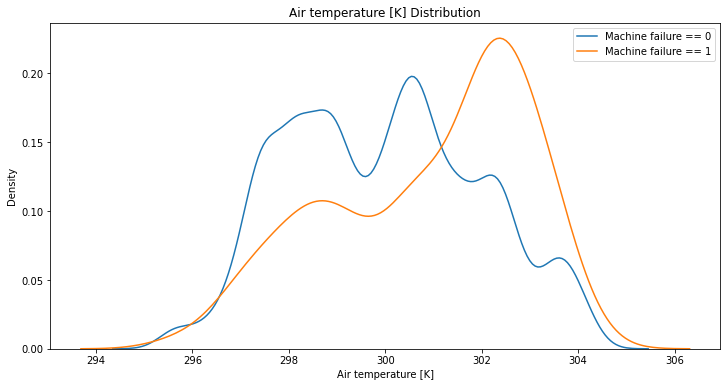

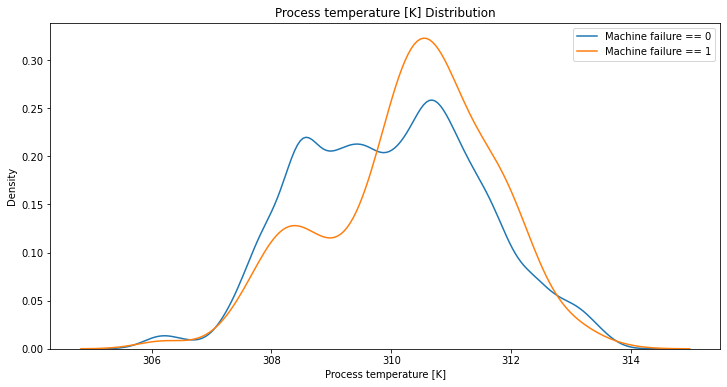

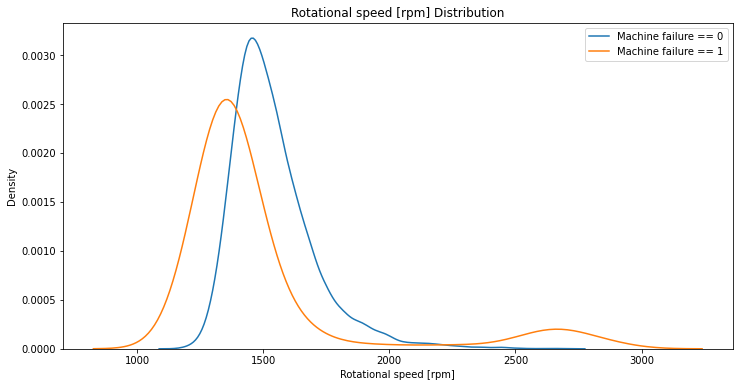

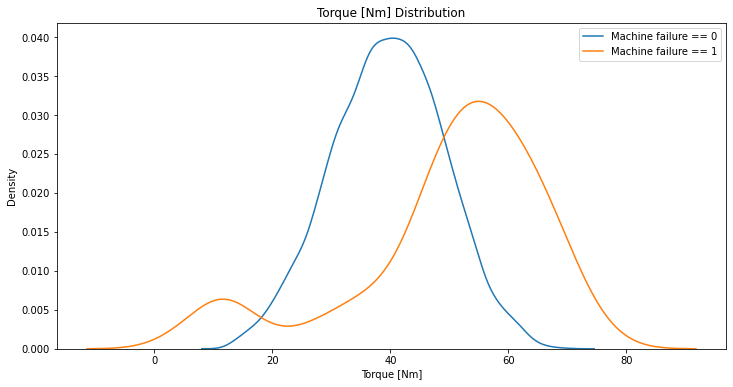

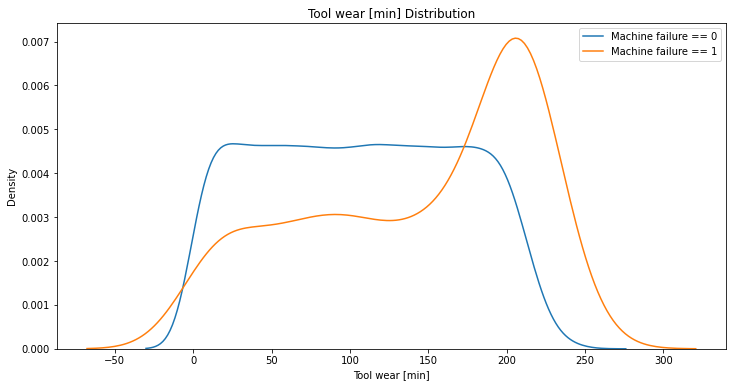

In [18]:
plot_kde(var_col_name = 'Air temperature [K]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Process temperature [K]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Rotational speed [rpm]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Torque [Nm]',
         target_col_name = 'Machine failure',
         df_plot = df)

plot_kde(var_col_name = 'Tool wear [min]',
         target_col_name = 'Machine failure',
         df_plot = df)

In [19]:
def plot_kde_multiple(var_col_name: str,
                      target_col_name: str,
                      df_plot: pd.DataFrame):
    plt.figure(figsize = (12, 6))

    # Plot the distribution
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'L')][var_col_name],
                label = 'Machine failure == 0, L',
                linestyle = "--",
                linewidth = 1)
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'M')][var_col_name],
                label = 'Machine failure == 0, M',
                linestyle = "--",
                linewidth = 2.5)
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 0) & (df_plot['Type'] == 'H')][var_col_name],
                label = 'Machine failure == 0, H',
                linestyle = "--",
                linewidth = 4)
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'L')][var_col_name],
                label = 'Machine failure == 1, L',
                linewidth = 1)
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'M')][var_col_name],
                label = 'Machine failure == 1, M',
                linewidth = 2.5)
    sns.kdeplot(df_plot[(df_plot[target_col_name] == 1) & (df_plot['Type'] == 'H')][var_col_name],
                label = 'Machine failure == 1, H',
                linewidth = 4)

    # label the plot
    plt.xlabel(var_col_name)
    plt.ylabel('Density')
    plt.title(f'{var_col_name} Distribution')
    plt.legend()


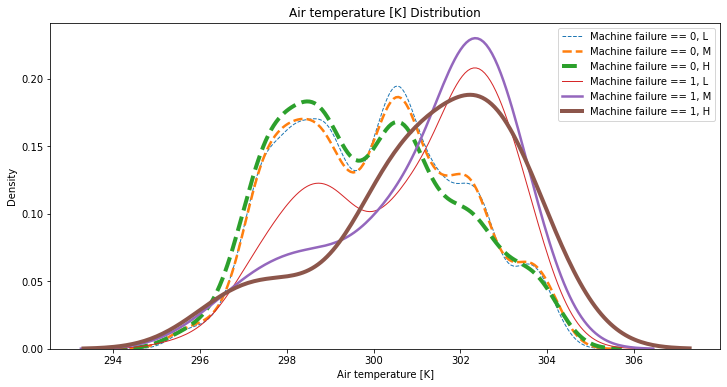

In [20]:
plot_kde_multiple(var_col_name = 'Air temperature [K]',
                  target_col_name = 'Machine failure',
                  df_plot = df)


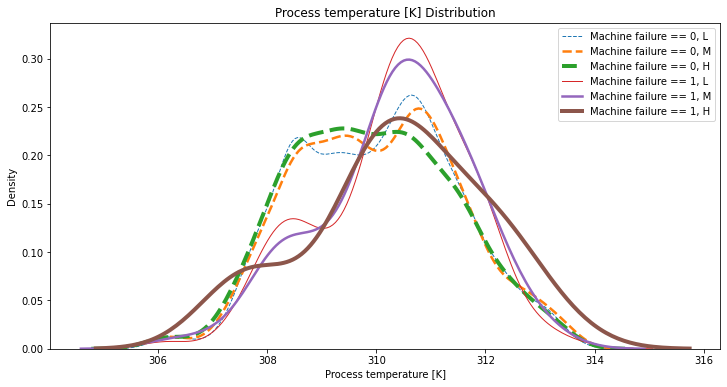

In [21]:
plot_kde_multiple(var_col_name = 'Process temperature [K]',
                  target_col_name = 'Machine failure',
                  df_plot = df)


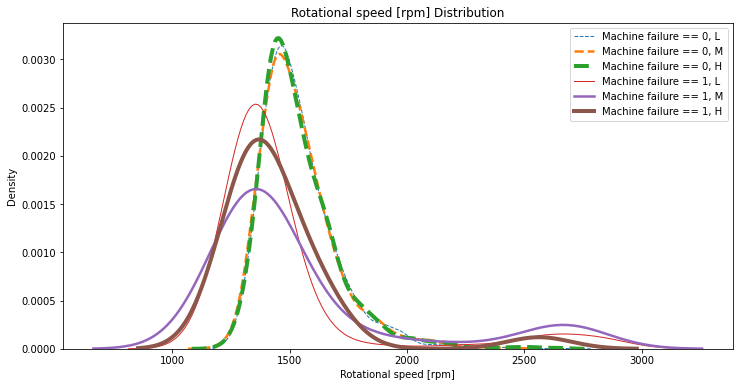

In [22]:
plot_kde_multiple(var_col_name = 'Rotational speed [rpm]',
                  target_col_name = 'Machine failure',
                  df_plot = df)



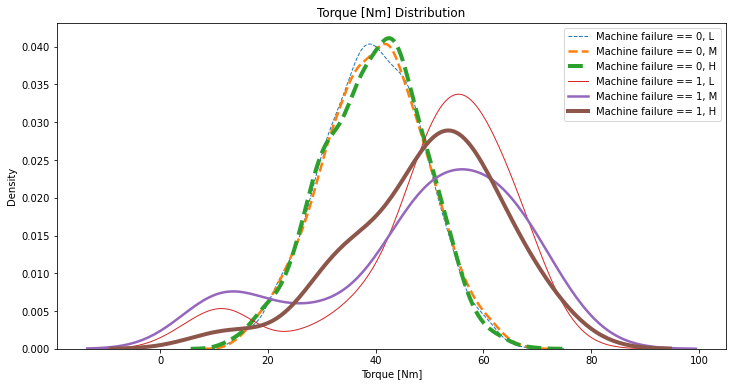

In [23]:
plot_kde_multiple(var_col_name = 'Torque [Nm]',
                  target_col_name = 'Machine failure',
                  df_plot = df)



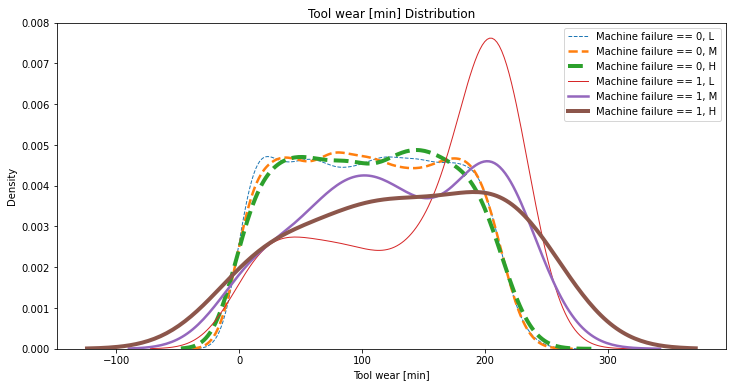

In [24]:
plot_kde_multiple(var_col_name = 'Tool wear [min]',
                  target_col_name = 'Machine failure',
                  df_plot = df)
